In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
import torch

from ebb.env.luxenv import get_ob_sapce
from ebb.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
    "use_agent": False,
}

# Load model

In [4]:
model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_2025026_imitation_r0/011321856_weights.pt"


ob_space = get_ob_sapce(obs_space_kwargs)
model = _create_model(ob_space, reward_spec=reward_spec, n_blocks=8, hidden_dim=128, base_out_channels=128,
                      embedding_dim=16, kernel_size=5)


checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(checkpoint_state["model_state_dict"])

<All keys matched successfully>

# Model Run

In [5]:
from luxai_s3.params import EnvParams

from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from ebb.env.luxenv import LuxS3Env
from ebb.env.wrappers import VecEnv, PytorchEnv, DictEnv
from ebb.torchbeast.core.selfplay import split_env_output_by_player, pair_env_output_for_players


def actor_model_apply(env_output, sample=True):
  lef_env_out, rig_env_out = split_env_output_by_player(env_output)
  lef_agent_out = actor_model(lef_env_out, sample=sample)
  rig_agent_out = actor_model(rig_env_out, sample=sample)
  return [(lef_env_out, lef_agent_out), (rig_env_out, rig_agent_out)]

def get_merged_actions(env_agent_out):
  lef_actions = env_agent_out[0][1]['actions']
  rig_actions = env_agent_out[1][1]['actions']
  return pair_env_output_for_players(lef_actions, rig_actions)

class AgentStats:

    def __init__(self):
        self.baseline = []


    def add_baseline(self, b):
        self.baseline.append(float(b.detach().numpy()))

        

In [8]:
game_env = LuxAIS3GymEnv(numpy_output=True)
game_env = RecordEpisode(game_env, save_dir="episodes1")

lux_env = LuxS3Env('match_explore_win_loss', 
                   obs_space_kwargs,
                   game_env,
                   reward_shaping_params=reward_shaping_params)
env = VecEnv([lux_env])
env = PytorchEnv(env, torch.device('cpu'))
env = DictEnv(env)

actor_model = model

# env_output = env.reset(force=True, seed=1331520750)
env_output = env.reset(force=True)

a1_stats = AgentStats()
a2_stats = AgentStats()


use_single_player = obs_space_kwargs['use_single_player']

while True:
    env_agent_output = actor_model_apply(env_output)
    a1_stats.add_baseline(env_agent_output[0][1]['baseline'][0][0])
    a2_stats.add_baseline(env_agent_output[1][1]['baseline'][0][0])

    actions = get_merged_actions(env_agent_output)
    env_output = env.step(actions)
    if env_output["done"].any():
        break

game_env.close()

lux_env._seed

452325403

<Axes: >

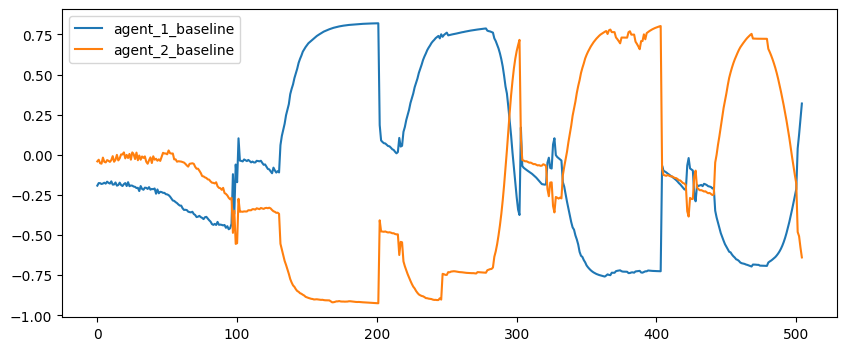

In [9]:
data = {
    'agent_1_baseline': a1_stats.baseline,
    'agent_2_baseline': a2_stats.baseline,   
}

pd.DataFrame(data)[['agent_1_baseline', 'agent_2_baseline']].plot(figsize=(10, 4))